In [81]:
import numpy as np
import torch

In [2]:
batch_size = 10**4
num_concepts = 10
num_latent_concepts = 5

In [3]:
# sampling from independent normals using parameterization trick
def sample(num_concepts, num_latent_concepts, batch_size):
    mu_hat = np.random.random(num_concepts).reshape(num_concepts, 1) # (n_concepts,  1)
    true_sigma_hat = np.random.random(num_concepts).reshape(num_concepts, 1) # (n_concepts,  1)
    c_hat = np.random.standard_normal(batch_size*num_concepts).reshape(batch_size, num_concepts, 1) * true_sigma_hat**0.5 + mu_hat # (batch_size, n_concepts,  1)

    mu_tilde = np.random.random(num_latent_concepts).reshape(num_latent_concepts, 1) # (n_latent,  1)
    true_sigma_tilde = np.random.random(num_latent_concepts).reshape(num_latent_concepts, 1) # (n_latent,  1)
    c_tilde = np.random.standard_normal(batch_size*num_latent_concepts).reshape(batch_size, num_latent_concepts, 1) * true_sigma_tilde**0.5 + mu_tilde # (batch_size, n_latent,  1)
    # print(list(true_sigma_hat.squeeze())+list(true_sigma_tilde.squeeze()))
    return c_hat, c_tilde

# c_hat_mean = np.mean(c_hat, axis=0) # (n_concepts, 1)
# c_tilde_mean = np.mean(c_tilde, axis=0) # (n_latent, 1)
# print(c_hat.shape, c_tilde.shape)

In [171]:
batch_size = 12
num_concepts = 10
num_latent_concepts = 5

In [112]:
def covariance_short(c_hat, c_tilde):
    c_hat = c_hat.squeeze(axis=-1).T
    c_tilde = c_tilde.squeeze(axis=-1).T
    samples = np.concatenate((c_hat, c_tilde), axis=0)
    
    samples_mean = np.mean(samples, axis=1)
    exey = np.outer(samples_mean, samples_mean)
    exy = np.zeros(exey.shape)
    cov_again = np.zeros(exey.shape)
    for i in range(exey.shape[0]):
        mean_row_i = np.mean(samples[i])
        sample_mean_row_i = np.sum(samples[i]) / (len(samples[i])-1)
        for j in range(exey.shape[1]):
            mean_row_j = np.mean(samples[j])
            sample_mean_row_j = np.sum(samples[j]) / (len(samples[j])-1)
            # cov_again[i,j] = np.mean(samples[i]*samples[j]) - mean_row_i*mean_row_j
            cov_again[i,j] = np.sum((samples[i]-mean_row_i) * (samples[j]-mean_row_j)) / (len(samples[j])-1)
            # cov_again[i,j] = np.sum( samples[i]*samples[j] - samples[i]*mean_row_j - mean_row_i*samples[j] + mean_row_i*mean_row_j ) / (len(samples[j])-1)
            # cov_again[i,j] = np.sum( samples[i]*samples[j] ) / (len(samples[j])-1) - sample_mean_row_i*mean_row_j - mean_row_i*sample_mean_row_j + mean_row_i*mean_row_j
            # cov_again[i,j] = np.sum(samples[i]*samples[j])/(samples.shape[1]) - mean_row_i*mean_row_j
            exy[i,j] = np.mean(samples[i]*samples[j])
    # print(exy.shape)
    # exy_true = np.cov(samples) + exey

    # print(exy)
    # print()
    # print(exy_true)


    cov = exy - exey
    return cov_again

def covariance_np(c_hat, c_tilde):
    c_hat = c_hat.squeeze(axis=-1).T
    c_tilde = c_tilde.squeeze(axis=-1).T
    samples = np.concatenate((c_hat, c_tilde), axis=0)
    
    return np.cov(samples)


    # print(samples_mean.shape)
    # cov = 

c_hat, c_tilde = sample(num_concepts, num_latent_concepts, batch_size)
sigma = covariance(c_hat, c_tilde)
sigma_np = covariance_np(c_hat, c_tilde)
print(sigma)
print()
print(sigma_np)

[[ 5.50801948  0.34928405 -1.23892489 -0.11905367  2.14910639  0.40555758
   0.31533124  1.64649657 -0.43002407  0.70916933 -0.63043551]
 [ 0.34928405  3.88679952 -0.72615895 -0.13777566 -0.86369586 -0.01565253
  -0.21964978  1.45482667  0.45473369  0.28833711 -1.66158596]
 [-1.23892489 -0.72615895  1.09417509  0.00714445 -0.76532203  0.0194465
  -0.09876495 -0.76703291  0.74452219 -0.2413108   0.23643475]
 [-0.11905367 -0.13777566  0.00714445  2.89089595  1.14839562 -0.10447844
  -0.32334484  0.3292649   0.57830816  1.53864522  0.33501168]
 [ 2.14910639 -0.86369586 -0.76532203  1.14839562  5.80118135 -0.18919827
  -0.17522312  2.24642314 -0.83515468  2.47589484  2.699616  ]
 [ 0.40555758 -0.01565253  0.0194465  -0.10447844 -0.18919827  0.1296983
   0.03599095  0.06759967 -0.02476861  0.30425554 -0.25990725]
 [ 0.31533124 -0.21964978 -0.09876495 -0.32334484 -0.17522312  0.03599095
   0.15628472 -0.11467802 -0.07175104 -0.35736829 -0.12685467]
 [ 1.64649657  1.45482667 -0.76703291  0.32

In [111]:
def covariance(c_hat, c_tilde):
    c_hat_mean = np.mean(c_hat, axis=0) # (n_concepts, 1)
    c_tilde_mean = np.mean(c_tilde, axis=0) # (n_latent, 1)
    c_stack_T = np.concatenate((c_hat,c_tilde), axis=1) # (batch_size, n_concepts+n_latent, 1)
    c_hat_mean_resize = np.repeat(c_hat_mean.reshape(1,num_concepts,1), batch_size, axis=0) # (batch_size, n_concepts, 1)
    c_tilde_mean_resize = np.repeat(c_tilde_mean.reshape(1,num_latent_concepts,1), batch_size, axis=0) # (batch_size, n_latent, 1)
    c_stack_mean_T = np.concatenate((c_hat_mean_resize,c_tilde_mean_resize), axis=1)  # (batch_size, n_concepts+n_latent, 1)
    c_stack_deviation = c_stack_T-c_stack_mean_T  # (batch_size, n_concepts+n_latent, 1)
    c_stack_deviation_T = np.moveaxis(c_stack_deviation,-1,-2)  # (batch_size, 1, n_concepts+n_latent)
    sigma = 1/(batch_size-1) * np.sum(np.matmul(c_stack_deviation,c_stack_deviation_T),axis=0)  # (batch_size, n_concepts+n_latent, n_concepts+n_latent)
    return sigma

In [111]:
c_hat, c_tilde = sample(num_concepts, num_latent_concepts, batch_size)
sigma_scratch = covariance(c_hat, c_tilde)
c_hat = c_hat.squeeze(axis=-1).T
c_tilde = c_tilde.squeeze(axis=-1).T
samples = np.concatenate((c_hat, c_tilde), axis=0)
sigma_np = np.cov(samples)
print(sigma_np)
print()
print(sigma_scratch)
print(np.sum(np.abs(sigma_scratch - sigma_np)))
print(np.linalg.det(sigma_np), np.linalg.det(sigma_scratch))

[0.8135731125215057, 0.7576167103399972, 0.31160523050571065, 0.8604086080584533]
[[ 0.67459205 -0.415014    0.00300902 -0.02950988]
 [-0.415014    1.25191919 -0.17795501 -0.46840892]
 [ 0.00300902 -0.17795501  0.27022026  0.0027806 ]
 [-0.02950988 -0.46840892  0.0027806   0.86797543]]

[[ 0.60713285 -0.3735126   0.00270811 -0.02655889]
 [-0.3735126   1.12672727 -0.16015951 -0.42156803]
 [ 0.00270811 -0.16015951  0.24319824  0.00250254]
 [-0.02655889 -0.42156803  0.00250254  0.78117789]]
0.5258061794321258
0.09648715386070177 0.06330522164800642


In [110]:
def loss_np(c_hat, c_tilde):
    c_hat = c_hat.squeeze(axis=-1).T
    c_tilde = c_tilde.squeeze(axis=-1).T
    samples = np.concatenate((c_hat, c_tilde), axis=0)
    sigma = np.cov(samples)
    # print(sigma)
    det_sigma = np.linalg.det(sigma)
    # print(det_sigma)
    log_det_sigma = np.log(det_sigma)

    # print(samples[c_hat.shape[0]:, c_hat.shape[0]:].shape)
    sigma_tilde = np.cov(samples[c_hat.shape[0]:, c_hat.shape[0]:])
    det_sigma_tilde = np.linalg.det(sigma_tilde)
    log_det_sigma_tilde = np.log(det_sigma_tilde) # scalar
    r = (log_det_sigma - log_det_sigma_tilde) / 2
    return r

In [107]:
def covariance(c_hat, c_tilde):
    c_hat_mean = np.mean(c_hat, axis=0) # (n_concepts, 1)
    c_tilde_mean = np.mean(c_tilde, axis=0) # (n_latent, 1)
    c_stack_T = np.concatenate((c_hat,c_tilde), axis=1) # (batch_size, n_concepts+n_latent, 1)
    c_hat_mean_resize = np.repeat(c_hat_mean.reshape(1,num_concepts,1), batch_size, axis=0) # (batch_size, n_concepts, 1)
    c_tilde_mean_resize = np.repeat(c_tilde_mean.reshape(1,num_latent_concepts,1), batch_size, axis=0) # (batch_size, n_latent, 1)
    c_stack_mean_T = np.concatenate((c_hat_mean_resize,c_tilde_mean_resize), axis=1)  # (batch_size, n_concepts+n_latent, 1)
    c_stack_deviation = c_stack_T-c_stack_mean_T  # (batch_size, n_concepts+n_latent, 1)
    c_stack_deviation_T = np.moveaxis(c_stack_deviation,-1,-2)  # (batch_size, 1, n_concepts+n_latent)
    sigma = 1/(batch_size-1) * np.sum(np.matmul(c_stack_deviation,c_stack_deviation_T),axis=0)  # (batch_size, n_concepts+n_latent, n_concepts+n_latent)
    return sigma

def loss(c_hat, c_tilde, covariance):
    # c_hat = c_hat.squeeze(axis=-1).T
    # c_tilde = c_tilde.squeeze(axis=-1).T
    # samples = np.concatenate((c_hat, c_tilde), axis=0)
    sigma = covariance(c_hat, c_tilde)
    # print(sigma)
    det_sigma = np.linalg.det(sigma)
    # print(det_sigma)
    log_det_sigma = np.log(det_sigma)

    # print(samples[c_hat.shape[0]:, c_hat.shape[0]:].shape)
    sigma_tilde = sigma[c_hat.shape[1]:, c_hat.shape[1]:]
    det_sigma_tilde = np.linalg.det(sigma_tilde)
    log_det_sigma_tilde = np.log(det_sigma_tilde) # scalar
    r = (log_det_sigma - log_det_sigma_tilde) / 2
    return r

In [113]:
def loss_term(c_hat, c_tilde):
    c_hat_mean = np.mean(c_hat, axis=0) # (n_concepts, 1)
    c_tilde_mean = np.mean(c_tilde, axis=0) # (n_latent, 1)

    c_stack_T = np.concatenate((c_hat,c_tilde), axis=1) # (batch_size, n_concepts+n_latent, 1)
    c_hat_mean_resize = np.repeat(c_hat_mean.reshape(1,num_concepts,1), batch_size, axis=0) # (batch_size, n_concepts, 1)
    c_tilde_mean_resize = np.repeat(c_tilde_mean.reshape(1,num_latent_concepts,1), batch_size, axis=0) # (batch_size, n_latent, 1)
    c_stack_mean_T = np.concatenate((c_hat_mean_resize,c_tilde_mean_resize), axis=1)  # (batch_size, n_concepts+n_latent, 1)
    c_stack_deviation = c_stack_T-c_stack_mean_T  # (batch_size, n_concepts+n_latent, 1)
    c_stack_deviation_T = np.moveaxis(c_stack_deviation,-1,-2)  # (batch_size, 1, n_concepts+n_latent)
    sigma = 1/(batch_size-1) * np.sum(np.matmul(c_stack_deviation,c_stack_deviation_T),axis=0)  # (batch_size, n_concepts+n_latent, n_concepts+n_latent)
    # sigma = covariance(c_hat, c_tilde)
    print(sigma.shape)
    log_det_sigma = np.log(np.linalg.det(sigma)) # scalar

    c_tilde_deviation = c_tilde-c_tilde_mean # (batch_size, n_latent, 1)
    c_tilde_deviation_T = np.moveaxis(c_tilde_deviation,-1,-2) # (batch_size, 1, n_latent)
    sigma_tilde = 1/(batch_size-1) * np.sum(np.matmul(c_tilde_deviation, c_tilde_deviation_T),axis=0)  # (n_latent, n_latent)
    # sigma_tilde = sigma[c_hat.shape[1]:, c_hat.shape[1]:]
    log_det_sigma_tilde = np.log(np.linalg.det(sigma_tilde)) # scalar

    r = (log_det_sigma - log_det_sigma_tilde) / 2
    return r

In [ ]:
batch_size = 10
num_concepts = 7
num_latent_concepts = 4

for _ in range(100):
    c_hat, c_tilde = sample(num_concepts, num_latent_concepts, batch_size)
    # r = loss_term(c_hat, c_tilde)
    # r_fast = loss_np(c_hat, c_tilde)
    r = loss(c_hat, c_tilde, covariance_np)
    # r_fast = loss(c_hat, c_tilde, covariance)
    r_fast = loss_term(c_hat, c_tilde)
    # print(r_fast)
    # if np.isnan(r_fast):
    #     break
    print(r, r_fast)
    # print(r)

/tmp/ipykernel_1304/3746537734.py:21: RuntimeWarning: divide by zero encountered in log
  log_det_sigma = np.log(det_sigma)
/tmp/ipykernel_1304/3746537734.py:26: RuntimeWarning: divide by zero encountered in log
  log_det_sigma_tilde = np.log(det_sigma_tilde) # scalar
/tmp/ipykernel_1304/3746537734.py:27: RuntimeWarning: invalid value encountered in scalar subtract
  r = (log_det_sigma - log_det_sigma_tilde) / 2
/tmp/ipykernel_1304/1979655526.py:14: RuntimeWarning: divide by zero encountered in log
  log_det_sigma = np.log(np.linalg.det(sigma)) # scalar
/tmp/ipykernel_1304/1979655526.py:20: RuntimeWarning: divide by zero encountered in log
  log_det_sigma_tilde = np.log(np.linalg.det(sigma_tilde)) # scalar
/tmp/ipykernel_1304/1979655526.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  r = (log_det_sigma - log_det_sigma_tilde) / 2


(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
nan nan
(132, 132)
n

In [115]:
print(r)

0.5875920078389916


In [44]:
batch_size = 64
num_concepts = 256
num_latent_concepts = 128

c_hat, c_tilde = sample(num_concepts, num_latent_concepts, batch_size*128)
# c = np.concatenate((c_hat, c_tilde), axis=1).squeeze().reshape(128, batch_size, num_concepts+num_latent_concepts)
c = c_hat.reshape(128, batch_size, num_concepts)
# # WRONG
# c_cov = []
# for i in range(c.shape[0]):
#     c_cov.append(np.cov(c[i], rowvar=True))
# c_cov = np.stack(c_cov, axis=0)
# c_cov_mean = np.mean(c_cov, axis=0)
# c_cov_std = np.std(c_cov, axis=0)
# print(c_cov.shape, c_cov_mean.shape, c_cov_std.shape)
# print(np.sum(c_cov_mean > 1.5))

(128, 64, 64) (64, 64) (64, 64)
64


In [83]:
# sampling from independent normals using parameterization trick
def sample(num_concepts, num_latent_concepts, batch_size):
    mu_hat = np.random.random(num_concepts).reshape(num_concepts, 1)*2 # (n_concepts,  1)
    true_sigma_hat = np.random.random(num_concepts).reshape(num_concepts, 1)*5 # (n_concepts,  1)
    c_hat = np.random.standard_normal(batch_size*num_concepts).reshape(batch_size, num_concepts, 1) * true_sigma_hat**0.5 + mu_hat # (batch_size, n_concepts,  1)

    mu_tilde = np.random.random(num_latent_concepts).reshape(num_latent_concepts, 1)*5 # (n_latent,  1)
    true_sigma_tilde = np.random.random(num_latent_concepts).reshape(num_latent_concepts, 1)*10 # (n_latent,  1)
    c_tilde = np.random.standard_normal(batch_size*num_latent_concepts).reshape(batch_size, num_latent_concepts, 1) * true_sigma_tilde**0.5 + mu_tilde # (batch_size, n_latent,  1)
    # print(list(true_sigma_hat.squeeze())+list(true_sigma_tilde.squeeze()))
    return c_hat, c_tilde

# c_hat_mean = np.mean(c_hat, axis=0) # (n_concepts, 1)
# c_tilde_mean = np.mean(c_tilde, axis=0) # (n_latent, 1)
# print(c_hat.shape, c_tilde.shape)

# sampling from independent normals using parameterization trick
def sample_c(num_concepts, batch_size):
    mu_hat = np.random.random(num_concepts).reshape(num_concepts)*2 # (n_concepts,  1)
    true_sigma_hat = np.random.random(num_concepts*num_concepts).reshape(num_concepts, num_concepts)
    true_sigma_hat = np.matmul(true_sigma_hat, true_sigma_hat.T)*5 # (n_concepts,  1)
    c_hat = np.random.multivariate_normal(mu_hat, true_sigma_hat, batch_size)
    return c_hat, mu_hat, true_sigma_hat

# c_hat_mean = np.mean(c_hat, axis=0) # (n_concepts, 1)
# c_tilde_mean = np.mean(c_tilde, axis=0) # (n_latent, 1)
# print(c_hat.shape, c_tilde.shape)

In [61]:
import matplotlib.pyplot as plt

In [107]:
def get_corr_to_std(batch_size, std=1, mean=0, samples=100):
    min_corr = -1
    max_corr = 1
    step = 0.01
    scale = 100
    corr_to_std = {}

    for corr in range(int(scale*min_corr), int((max_corr+step)*scale), int(step*scale)):
        corr /= scale
        cov_matrix = np.ones((2,2))
        np.fill_diagonal(cov_matrix, std**2)
        cov_matrix[0,1] = corr*std**2
        cov_matrix[1,0] = corr*std**2
        z = np.random.multivariate_normal(np.ones(2)*mean, cov_matrix, (samples, batch_size))
        corr_z = []
        for sample in z:
            # print(sample.shape)
            # print(np.corrcoef(sample, rowvar=False))
            corr_z.append(np.corrcoef(sample, rowvar=False)[0,1])
        std_corr_z = np.std(corr_z)
        corr_to_std[int(corr*scale)] = std_corr_z

        def get_std(correlation): # interpolation
            return corr_to_std[int(round(correlation, 2)*scale)]
            # if correlation == 1:
            #     return corr_to_std[correlation]
            # if correlation < step:
            #     return corr_to_std[0]*correlation*100 + corr_to_std[int(step*scale)]*(1-correlation*100)
            # corr_truncate = int(correlation * scale) / scale
            # alpha = int(correlation*scale*100) % int(corr_truncate*scale*100) / 100 # 0.1234 -> 0.34   (1234%1200)
            # return corr_to_std[int(corr_truncate*scale)]*alpha + corr_to_std[int((corr_truncate+step)*scale)]*(1-alpha)
    return get_std

print(get_corr_to_std(batch_size)(0.8160156425812756))

0.1410018950545684


In [126]:
num_concepts = 500
batch_size = 64
c_hat, mu_hat, true_sigma_hat = sample_c(num_concepts, batch_size)
get_std = np.vectorize(get_corr_to_std(batch_size))
def get_cov(c, get_std, delta=1):
    concepts = c.shape[1]
    # c = np.concatenate((c_hat, c_tilde), axis=1).squeeze() # 64, 256+128
    p_hat = np.corrcoef(c, rowvar=False) # 256+128, 256+128
    np.fill_diagonal(p_hat, 0.99999)

    # calculate S_p
    S_p = np.sum(get_std(p_hat)**2)**0.5
    

    # estimate gamma
    for gamma in range(2, 10, 2):
        p_hat_gamma = p_hat**gamma * p_hat
        print('gamma:', gamma, np.linalg.norm(p_hat - p_hat_gamma), delta * S_p)
        if np.linalg.norm(p_hat - p_hat_gamma) >= delta * S_p:
            gamma_star = gamma
            break

    # estimate alpha
    scale = 1000
    step = 0.1
    for alpha in range(0, int((1+step)*scale), int(step*scale)):
        alpha /= scale
        L_alpha = alpha * p_hat ** gamma_star + (1-alpha) *p_hat ** (gamma_star-2)
        p_hat_alpha = L_alpha * p_hat
        print('alpha:', alpha, np.linalg.norm(p_hat - p_hat_alpha), delta * S_p)
        if np.linalg.norm(p_hat - p_hat_alpha) >= delta * S_p:
            alpha_star = alpha - step
            break
    print(alpha_star, gamma_star)

    L_alpha_star = alpha_star * p_hat ** gamma_star + (1-alpha_star) *p_hat ** (gamma_star-2)
    p_hat_nice = L_alpha_star * p_hat

    V_hat = np.diagflat(np.std(c, axis=0))
    P_hat_nice = np.matmul(np.matmul(V_hat, p_hat_nice), V_hat) # Covariance estimate
    return P_hat_nice

print(type(c_hat))
sigma_hat = get_cov(c_hat, get_std)
np_sigma = np.cov(c_hat, rowvar=False)
# print(np_sigma.shape)
# print(true_sigma_hat)
# print()
# print(sigma_hat)
print(np.mean(np.absolute(true_sigma_hat-sigma_hat)), np.mean(np.absolute(true_sigma_hat)), np.mean(np.absolute(sigma_hat)))

print(np.mean(np.absolute(true_sigma_hat-np_sigma)), np.mean(np.absolute(true_sigma_hat)), np.mean(np.absolute(np_sigma)))
print(np.linalg.slogdet(true_sigma_hat))
print(np.linalg.slogdet(sigma_hat))
print(np.linalg.slogdet(np_sigma))


<class 'numpy.ndarray'>
gamma: 2 149.34170877816973 24.552049911716285
alpha: 0.0 0.0 24.552049911716285
alpha: 0.1 14.934170877816962 24.552049911716285
alpha: 0.2 29.868341755633924 24.552049911716285
0.1 2
84.53586801180836 625.736967331119 701.4422959321189
117.23117516515754 625.736967331119 740.4640436834289
SlogdetResult(sign=1.0, logabsdet=2171.4133422523823)
SlogdetResult(sign=1.0, logabsdet=1439.6220783076865)
SlogdetResult(sign=1.0, logabsdet=-10942.043162644797)


In [121]:
print(true_sigma_hat,'\n')
print(sigma_hat,'\n')
print(np_sigma,'\n')

[[832.55805317 671.5235633  637.38296223 ... 599.1144783  618.77690238
  603.01423257]
 [671.5235633  873.46720694 658.22410253 ... 625.33437358 637.6742321
  638.26175424]
 [637.38296223 658.22410253 851.4920577  ... 620.80055349 627.63159767
  617.57867465]
 ...
 [599.1144783  625.33437358 620.80055349 ... 776.92348255 587.69406409
  609.85106122]
 [618.77690238 637.6742321  627.63159767 ... 587.69406409 833.40284741
  613.44695901]
 [603.01423257 638.26175424 617.57867465 ... 609.85106122 613.44695901
  803.3724249 ]] 

[[ 973.21404205  825.07636767  743.4229834  ...  757.76279181
   814.35190281  739.49803341]
 [ 825.07636767 1098.12794627  784.653308   ...  857.67953162
   864.36952811  776.62903896]
 [ 743.4229834   784.653308   1008.83785437 ...  843.04013998
   817.6209166   718.30296049]
 ...
 [ 757.76279181  857.67953162  843.04013998 ... 1002.72035987
   846.81564493  728.48260921]
 [ 814.35190281  864.36952811  817.6209166  ...  846.81564493
  1176.19488062  766.30338737]
 

In [133]:
c_hat, c_tilde = sample(num_concepts, num_latent_concepts, batch_size)
c_hat = torch.tensor(c_hat)
c_tilde = torch.tensor(c_tilde)
batch_size = c_hat.shape[0]
concepts = c.shape[1]
c = torch.concatenate((c_hat, c_tilde), axis=1).squeeze() # 64, 256+128
p_hat = torch.corrcoef(c.T) # 256+128, 256+128
p_hat.fill_diagonal_(0.99999)

mu = torch.arctanh(p_hat.flatten())
z_hat = torch.normal(torch.repeat_interleave(torch.tensor(mu), m), torch.repeat_interleave(torch.tensor(1/(batch_size-3)),m*concepts**2)).reshape(m, concepts**2)
# z_hat = np.random.standard_normal(m*concepts*concepts).reshape(m, concepts*concepts) * 1/(batch_size-3)**0.5 + torch.arctanh(p_hat.reshape(1,concepts*concepts))
p_var = torch.var(torch.tanh(z_hat), axis=0)
S_p = torch.sqrt(torch.sum(p_var))

# estimate gamma
for gamma in range(2, 10, 2):
    p_hat_gamma = p_hat**gamma * p_hat
    if torch.norm(p_hat - p_hat_gamma) >= delta * S_p:
        gamma_star = gamma
        break

# estimate alpha
scale = 1000
step = 0.1
for alpha in range(0, int((1+step)*scale), int(step*scale)):
    alpha /= scale
    L_alpha = alpha * p_hat ** gamma_star + (1-alpha) *p_hat ** (gamma_star-2)
    p_hat_alpha = L_alpha * p_hat
    if torch.norm(p_hat - p_hat_alpha) >= delta * S_p:
        alpha_star = alpha - step

L_alpha_star = alpha_star * p_hat ** gamma_star + (1-alpha_star) *p_hat ** (gamma_star-2)
p_hat_nice = L_alpha_star * p_hat

V_hat = torch.diagflat(torch.std(c, axis=0))
P_hat_nice = torch.matmul(torch.matmul(V_hat, p_hat_nice), V_hat) # Covariance estimate

print(-0.5 * torch.log(torch.linalg.det(P_hat_nice[-c_tilde.shape[1]:, -c_tilde.shape[1]:]) / torch.linalg.det(P_hat_nice)))

tensor(2.6201, dtype=torch.float64)


/tmp/ipykernel_1304/3361954235.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_hat = torch.normal(torch.repeat_interleave(torch.tensor(mu), m), torch.repeat_interleave(torch.tensor(1/(batch_size-3)),m*concepts**2)).reshape(m, concepts**2)


In [79]:
np.tanh(np.arctanh(1))

/tmp/ipykernel_1304/290463341.py:1: RuntimeWarning: divide by zero encountered in arctanh
  np.tanh(np.arctanh(1))


1.0

In [50]:
np.arange(10).reshape(5,2) * np.arange(5).reshape(5,1)

array([[ 0,  0],
       [ 2,  3],
       [ 8, 10],
       [18, 21],
       [32, 36]])

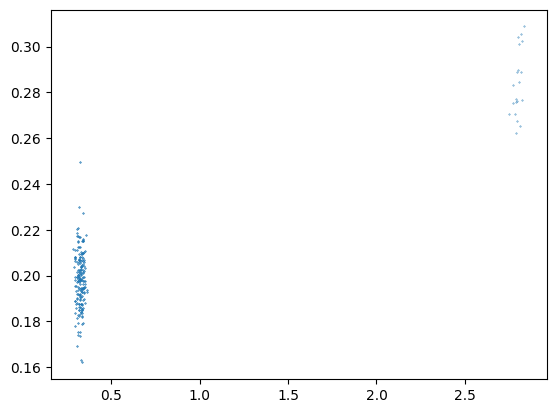

In [43]:
plt.scatter(c_cov_mean.flatten(), c_cov_std.flatten(), s=0.1)
# plt.hist(c_cov.flatten())
plt.show()

In [22]:
import matplotlib.pyplot as plt

In [45]:
print(c_cov_mean)

[[2.85758443 0.34428316 0.34187303 ... 0.30198384 0.3421407  0.31602216]
 [0.34428316 2.82694093 0.33168922 ... 0.35264139 0.33767396 0.34207855]
 [0.34187303 0.33168922 2.85041625 ... 0.33417808 0.34173658 0.31345031]
 ...
 [0.30198384 0.35264139 0.33417808 ... 2.8211648  0.34391872 0.34208158]
 [0.3421407  0.33767396 0.34173658 ... 0.34391872 2.82132786 0.33203742]
 [0.31602216 0.34207855 0.31345031 ... 0.34208158 0.33203742 2.85716297]]


In [16]:
print(np.arange(10).reshape(2,5))

[[0 1 2 3 4]
 [5 6 7 8 9]]
